In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from utils import SphericalNODataset, get_cr_dirs
from io import BytesIO
import imageio.v2 as imageio
from torch_harmonics import RealSHT
import torch
from torch_harmonics import InverseRealSHT

In [ ]:
def analyze_sht_reconstruction_code2_way(data, candidate_lmax, candidate_mmax, norm='ortho', grid='equiangular'):
    """
    Analyze and visualize SHT energy spectrum and reconstruction quality at different (l_max, m_max),
    using the SFNO-style approach (truncate at SHT time via s=(lmax, mmax)).
    """

    nlat, nlon = data.shape
    data_tensor = torch.from_numpy(data).unsqueeze(0).unsqueeze(0).float()

    # Reconstruction tests with 3 columns: Reconstruction | Ground truth | Error map
    fig, axs = plt.subplots(len(candidate_lmax) * len(candidate_mmax), 3, figsize=(12, 3 * len(candidate_lmax) * len(candidate_mmax)))

    for i, l_max_cut in enumerate(candidate_lmax):
        for j, m_max_cut in enumerate(candidate_mmax):
            # Use SFNO style: directly compute SHT with (l_max_cut, m_max_cut)
            sht = RealSHT(nlat=nlat, nlon=nlon, lmax=l_max_cut, mmax=m_max_cut, norm=norm, grid=grid)
            isht = InverseRealSHT(nlat=nlat, nlon=nlon, lmax=l_max_cut, mmax=m_max_cut, norm=norm, grid=grid)

            coeffs = sht(data_tensor)
            reconstructed = isht(coeffs).squeeze().detach().numpy()

            # Compute relative L2 error (global)
            relative_error = np.linalg.norm(reconstructed - data) / np.linalg.norm(data)

            # Compute pixel-wise absolute error
            abs_error_map = np.abs(reconstructed - data)

            idx = i * len(candidate_mmax) + j
            
            v_min = np.min(data)
            v_max = np.max(data)

            # Left: reconstruction
            ax = axs[idx, 0]
            ax.imshow(reconstructed, origin='lower', aspect='auto', cmap='gnuplot', vmin=v_min, vmax=v_max)
            ax.set_title(f'Reconstruction\nl={l_max_cut}, m={m_max_cut}\nL2 Error={relative_error:.3e}')
            ax.axis('off')

            # Middle: ground truth
            ax = axs[idx, 1]
            ax.imshow(data, origin='lower', aspect='auto', cmap='gnuplot', vmin=v_min, vmax=v_max)
            ax.set_title(f'Ground truth')
            ax.axis('off')

            # Right: error map
            im = ax = axs[idx, 2]
            im = ax.imshow(abs_error_map, origin='lower', aspect='auto', cmap='magma')
            ax.set_title(f'Error map')
            ax.axis('off')

            # Add colorbar only to the error map
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


In [8]:
def analyze_sht_grids(data, candidate_lmax, candidate_mmax, norm='ortho'):
    """
    Analyze and visualize SHT reconstruction quality at different (l_max, m_max),
    comparing equiangular, Legendre-Gauss, and Lobatto grids.

    Columns:
    [0] Equiangular | [1] Legendre-Gauss | [2] Lobatto | [3] Ground truth
    """

    nlat, nlon = data.shape
    data_tensor = torch.from_numpy(data).unsqueeze(0).unsqueeze(0).float()

    # Plotting setup: 4 columns (Equi, Gauss, Lobatto, GT)
    fig, axs = plt.subplots(len(candidate_lmax) * len(candidate_mmax), 4, figsize=(16, 3 * len(candidate_lmax) * len(candidate_mmax)))

    for i, l_max_cut in enumerate(candidate_lmax):
        for j, m_max_cut in enumerate(candidate_mmax):
            # Equiangular grid
            sht_equi = RealSHT(nlat=nlat, nlon=nlon, lmax=l_max_cut, mmax=m_max_cut, norm=norm, grid='equiangular')
            isht_equi = InverseRealSHT(nlat=nlat, nlon=nlon, lmax=l_max_cut, mmax=m_max_cut, norm=norm, grid='equiangular')
            coeffs_equi = sht_equi(data_tensor)
            recon_equi = isht_equi(coeffs_equi).squeeze().detach().numpy()
            error_equi = np.linalg.norm(recon_equi - data) / np.linalg.norm(data)

            # Legendre-Gauss grid
            sht_gauss = RealSHT(nlat=nlat, nlon=nlon, lmax=l_max_cut, mmax=m_max_cut, norm=norm, grid='legendre-gauss')
            isht_gauss = InverseRealSHT(nlat=nlat, nlon=nlon, lmax=l_max_cut, mmax=m_max_cut, norm=norm, grid='legendre-gauss')
            coeffs_gauss = sht_gauss(data_tensor)
            recon_gauss = isht_gauss(coeffs_gauss).squeeze().detach().numpy()
            error_gauss = np.linalg.norm(recon_gauss - data) / np.linalg.norm(data)

            # Lobatto grid
            sht_lobatto = RealSHT(nlat=nlat, nlon=nlon, lmax=l_max_cut, mmax=m_max_cut, norm=norm, grid='lobatto')
            isht_lobatto = InverseRealSHT(nlat=nlat, nlon=nlon, lmax=l_max_cut, mmax=m_max_cut, norm=norm, grid='lobatto')
            coeffs_lobatto = sht_lobatto(data_tensor)
            recon_lobatto = isht_lobatto(coeffs_lobatto).squeeze().detach().numpy()
            error_lobatto = np.linalg.norm(recon_lobatto - data) / np.linalg.norm(data)

            # Plot index for current row
            idx = i * len(candidate_mmax) + j
            v_min = np.min(data)
            v_max = np.max(data)

            # Leftmost: Equiangular reconstruction
            ax = axs[idx, 0]
            ax.imshow(recon_equi, origin='lower', aspect='auto', cmap='gnuplot', vmin=v_min, vmax=v_max)
            ax.set_title(f'Equiangular\nl={l_max_cut}, m={m_max_cut}\nL2={error_equi:.3e}')
            ax.axis('off')

            # 2nd: Legendre-Gauss reconstruction
            ax = axs[idx, 1]
            ax.imshow(recon_gauss, origin='lower', aspect='auto', cmap='gnuplot', vmin=v_min, vmax=v_max)
            ax.set_title(f'Legendre-Gauss\nL2={error_gauss:.3e}')
            ax.axis('off')

            # 3rd: Lobatto reconstruction
            ax = axs[idx, 2]
            ax.imshow(recon_lobatto, origin='lower', aspect='auto', cmap='gnuplot', vmin=v_min, vmax=v_max)
            ax.set_title(f'Lobatto\nL2={error_lobatto:.3e}')
            ax.axis('off')

            # Rightmost: Ground truth
            ax = axs[idx, 3]
            ax.imshow(data, origin='lower', aspect='auto', cmap='gnuplot', vmin=v_min, vmax=v_max)
            ax.set_title(f'Ground truth')
            ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
data_path = '~/train'

In [10]:
cr_dirs = get_cr_dirs(data_path)
print(len(cr_dirs))
dataset = SphericalNODataset(data_path, cr_dirs)

25


Loading simulations: 100%|██████████| 25/25 [00:00<00:00, 77.07it/s]


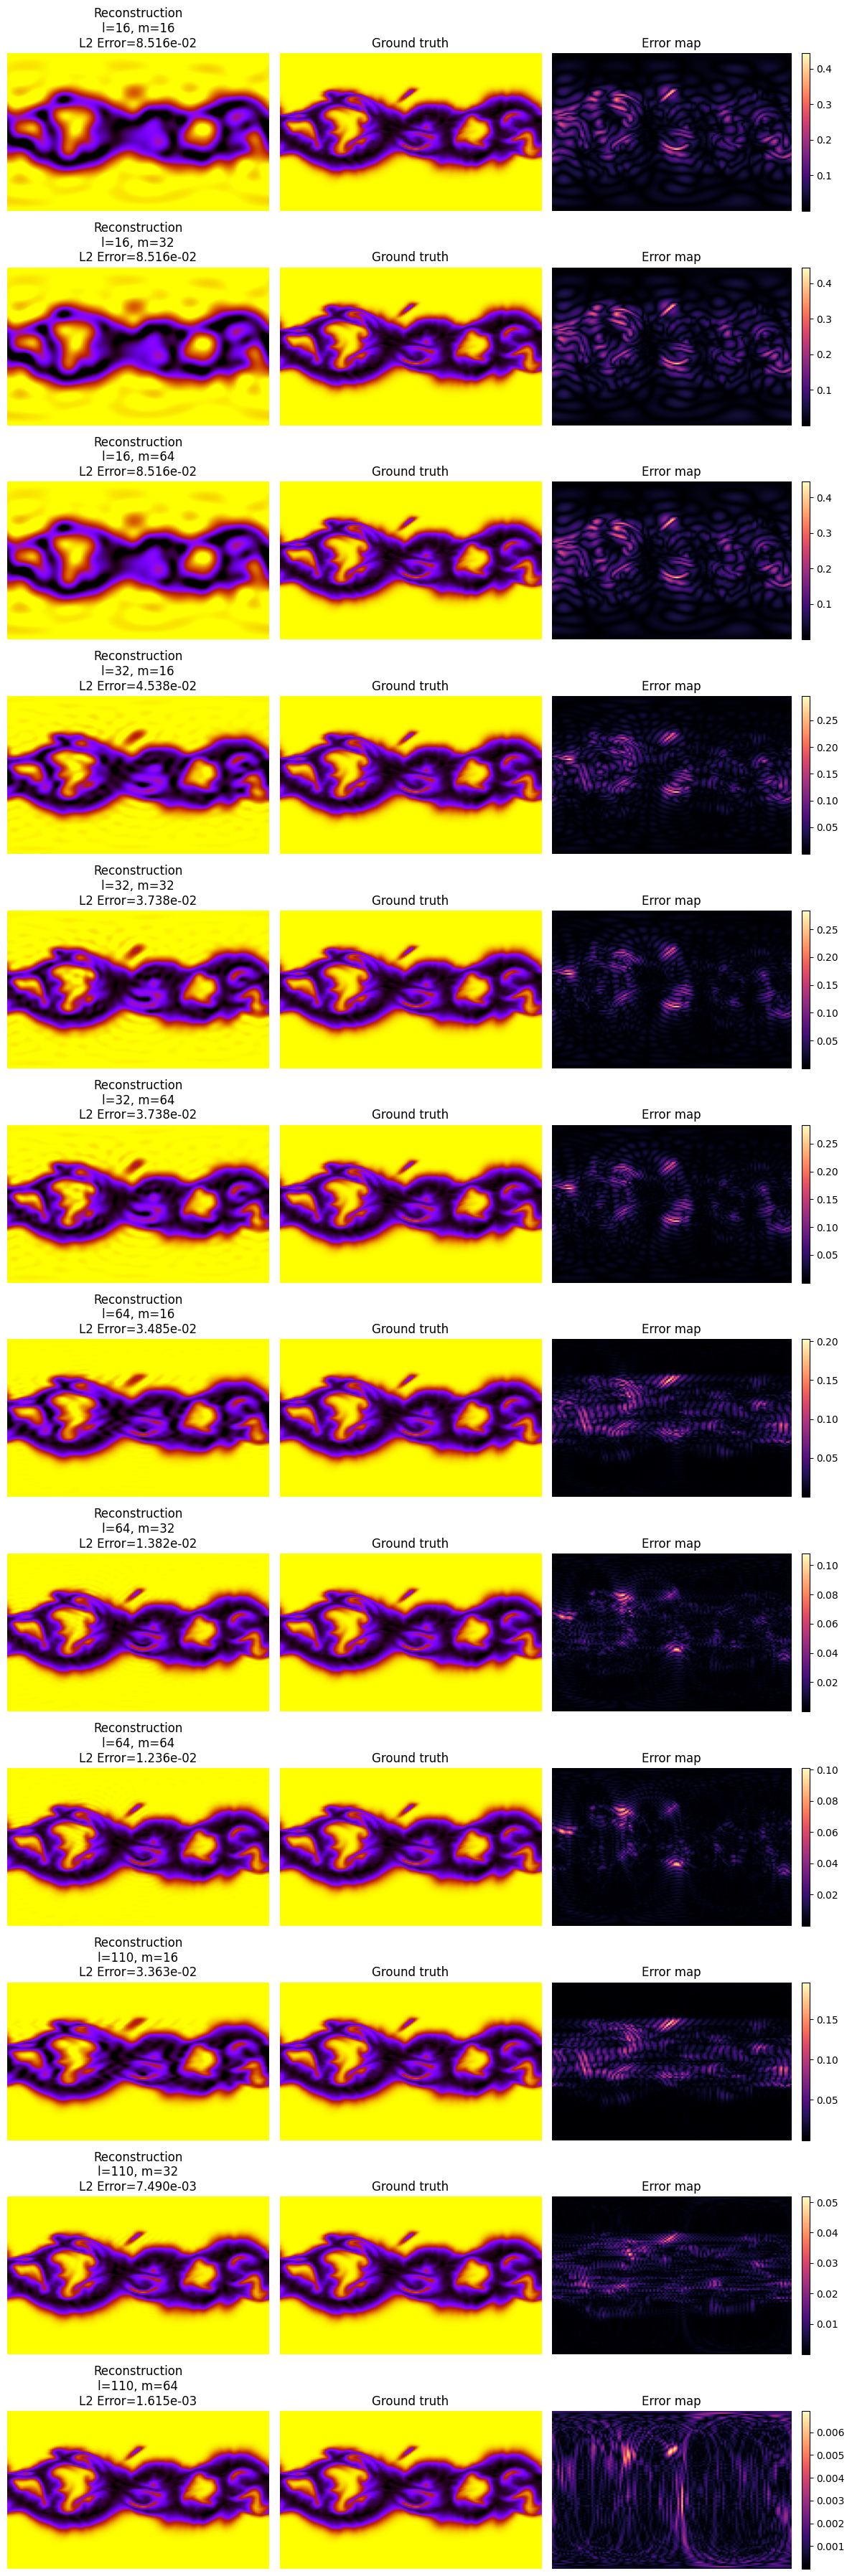

In [11]:
I = 0
data = dataset[I]['x'][0].numpy()
analyze_sht_reconstruction_code2_way(
    data=data,
    candidate_lmax=[16, 32, 64, 110],
    candidate_mmax=[16, 32, 64]
)

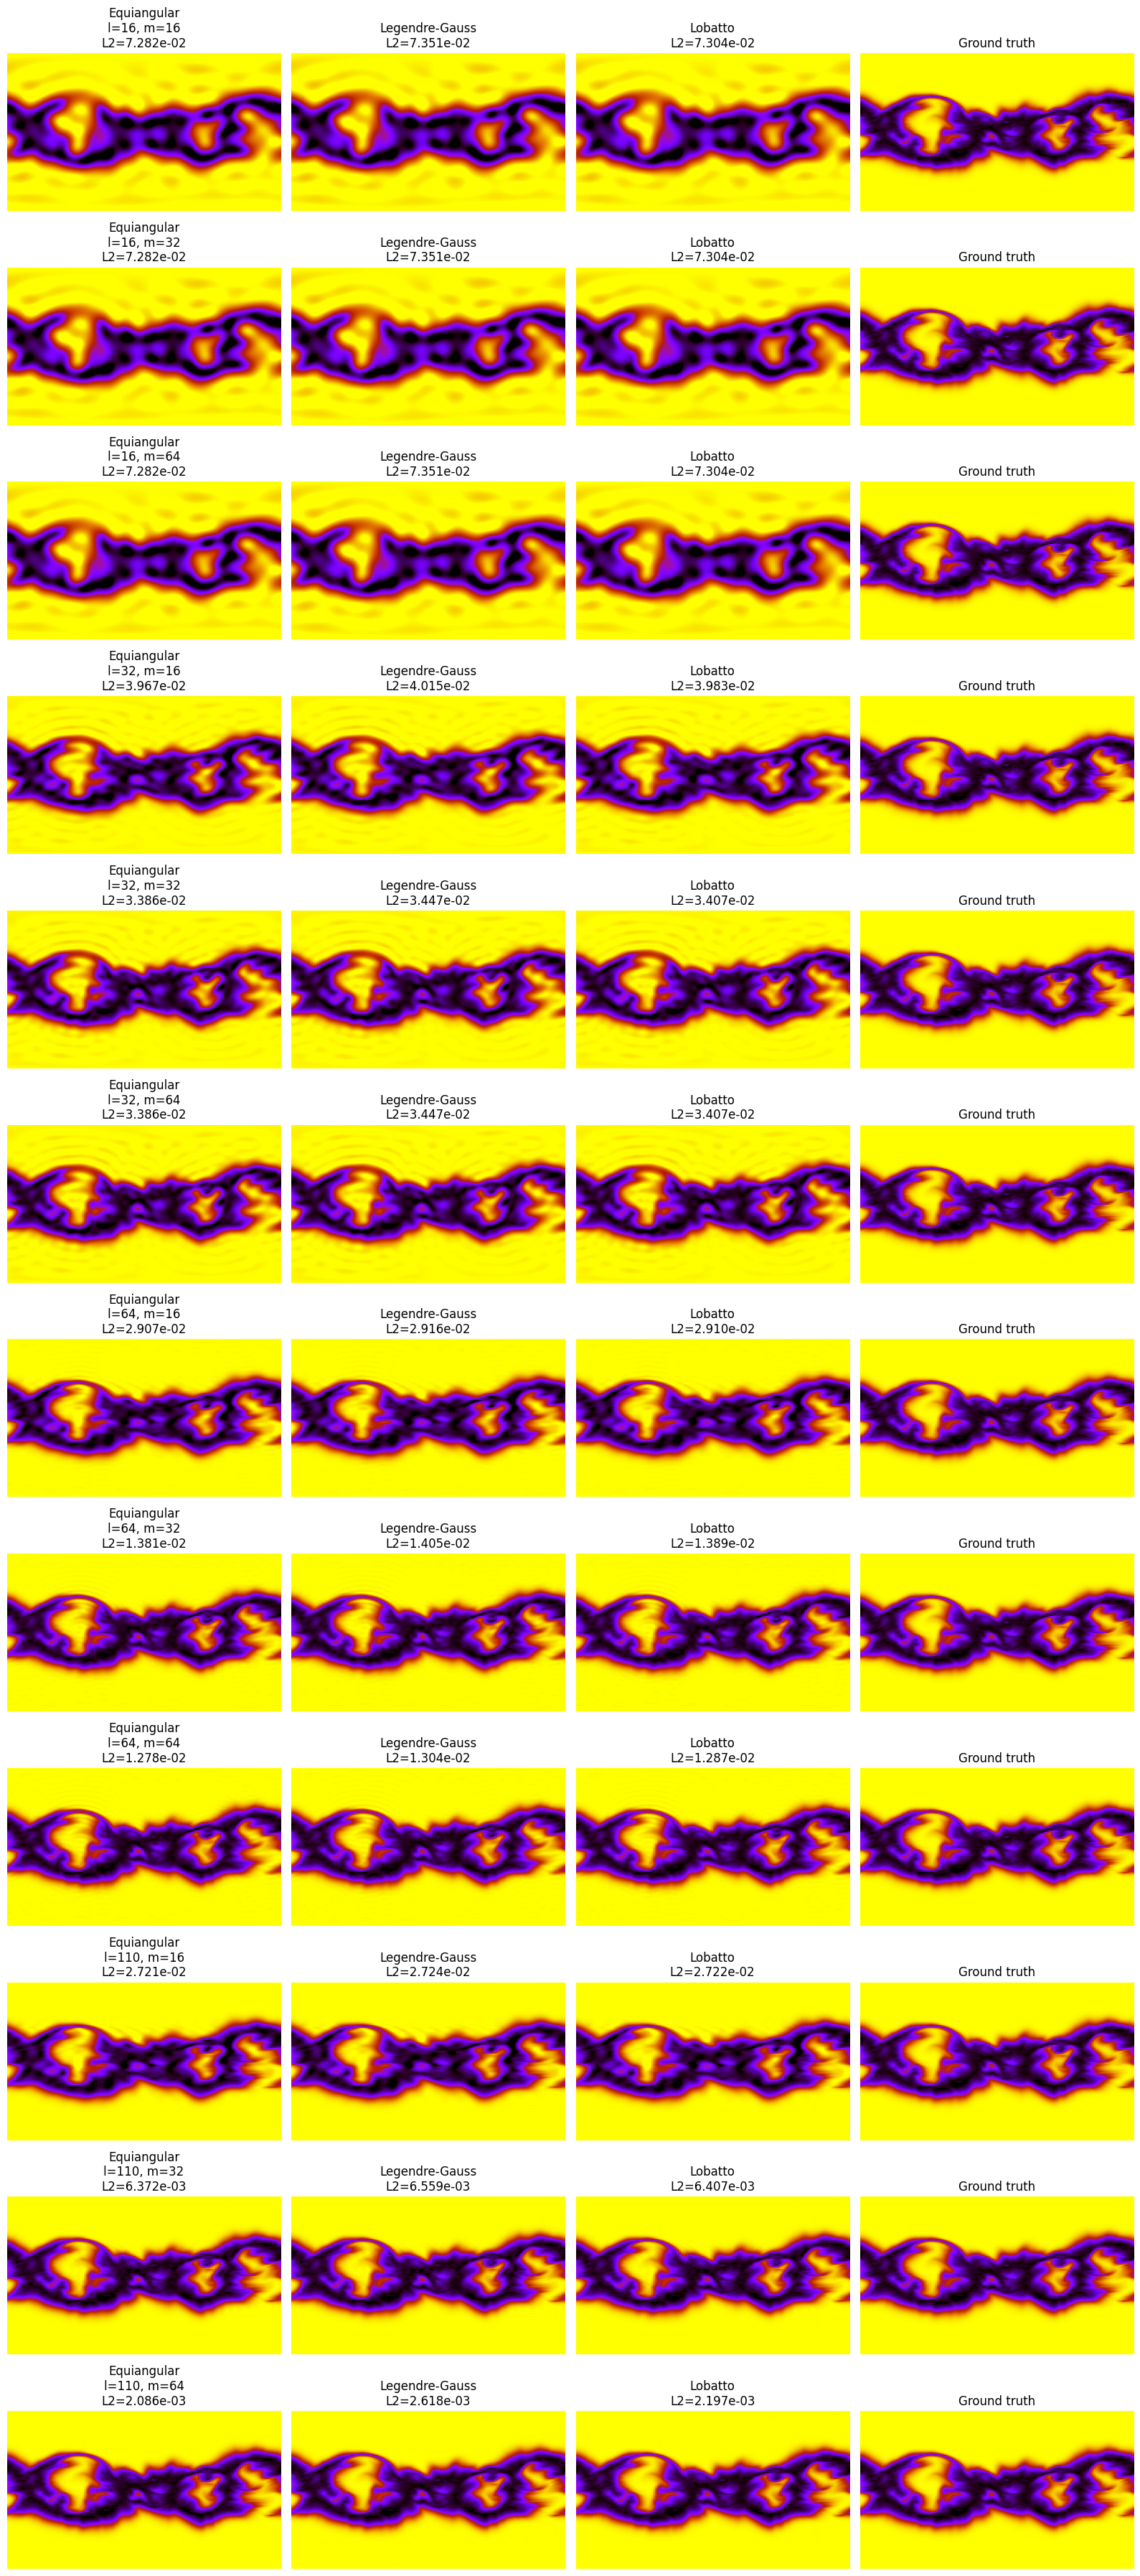

In [13]:
I = 1
data = dataset[I]['x'][0].numpy()
analyze_sht_grids(
    data=data,
    candidate_lmax=[16, 32, 64, 110],
    candidate_mmax=[16, 32, 64]
)